# Распознавание модели автомобилей на изображениях

## Данные

На данном этапе поддерживаются только 10 моделей автомобилей:
 - Honda Civic
 - Hyundai Accent
 - Hyundai Solaris
 - KIA Cee'd
 - KIA Rio
 - Lada Kalina
 - Mazda 3
 - Nissan Qashqai
 - Opel Astra
 - Toyota Camry
 
Из датасета были отобраны "удачные" фотографии автомобилей. Далее они были обрезаны таким образом, чтобы убрать с фотографии все лишнее. Все полученные изображения имеют пропорции 4x5.

Вспомогательная функция, для отображения галлереи.

In [1]:
import matplotlib.pylab as plt
%matplotlib inline

def plot_gallery(gallery, n_row, n_col, row_labels):
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(1.7 * n_col, 1.7 * n_row))
    
    for plot, img in zip(axes.ravel(), gallery):
        plot.imshow(img, interpolation='nearest')
        plot.set_xticks(())
        plot.set_yticks(())
    
    for ax, label in zip(axes[:, 0], row_labels):
        ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    fig.subplots_adjust(left=.15, right=.9, bottom=0, top=0.9, wspace=0.2, hspace=0.35)
    fig.tight_layout()

Отобразим фотографии нескольких автомобилей из каждого класса.

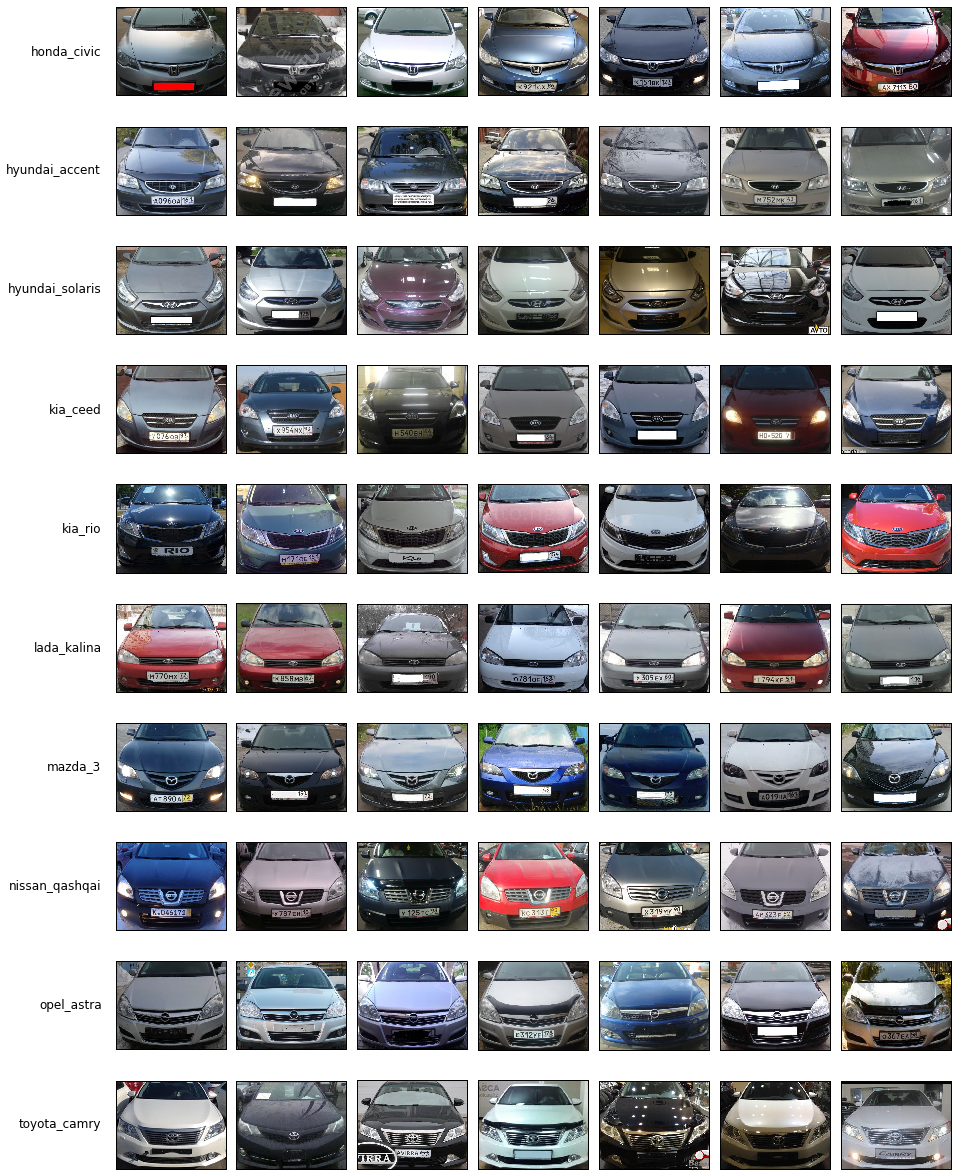

In [2]:
import glob
from itertools import islice
from skimage import io

models = ["honda_civic", "hyundai_accent", "hyundai_solaris", "kia_ceed", "kia_rio",
          "lada_kalina", "mazda_3", "nissan_qashqai", "opel_astra", "toyota_camry"]

gallery = []
for model in models:
    img_paths = glob.iglob("dataset/cropped/{}/*".format(model))
    gallery.extend(io.imread(img_path) for img_path in islice(img_paths, 7))

plot_gallery(gallery, n_row=10, n_col=7, row_labels=models)

## Оценка качества модели

В качестве схемы кросс-валидации используется 5-fold cv, заданная с помощью класса [KFoldCV](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html).

Для оценки качества предсказания классификатора используется наиболее очевидная метрика, а именно доля правильных ответов (accuracy):
$$accuracy = \frac{1}{n} \sum\limits_{i=1}^{n} [\alpha(x_i) = y_i]$$

In [3]:
from sklearn.cross_validation import cross_val_score, KFold, train_test_split

Функция для построения графика с результатами

In [4]:
import matplotlib.pylab as plt
import numpy as np

%matplotlib inline

def plot_quality(grid_scores, param, param_name):
    means = []
    stds = []
    for cv_validation_scores in grid_scores:
        means.append(np.mean(cv_validation_scores))
        stds.append(np.sqrt(np.var(cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)

    plt.figure(figsize=(8, 6))
    plt.plot(param, means)
    plt.fill_between(param, means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")

## Представление данных

Для описания фотографий автомобилей мы будем использовать дескриптор, известный под названием [Histogram of Oriented Gradient](http://scikit-image.org/docs/dev/auto_examples/plot_hog.html) (далее просто HOG). Это популярный дескриптор в задачах обнаружения объектов. При помощи него можно отлично описывать объекты, имеющие "жесткую" модель, что как раз подходит для нашей задачи.

Дескриптор имеет несколко параметров. Нас будут интересовать два из них:
- pixels_per_cell - размер (в пикселях) каждой ячеейки
- cells_per_block - число ячеек в каждом блоке

По-умолчанию будем использовать размер ячейки 16x16 и размер блока 2x2, что обеспечит баланс между пространственной поддержкой дескриптора и размером его вектора.

In [5]:
from skimage.feature import hog

## Первая модель - Random Forest

В качестве первой модели будем использовать [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Причиной тому является то, что данная модель способна показывать впечатляющие результаты даже без тонкой настройки её параметров. В качестве значения параметра, отвечающего за количество деревьев в лесе (*n_estimators*) выберем достаточно большое число - 300, т.к. данная модель не переобучается с увеличением количества деревьев.

In [6]:
from skimage import transform, io
from sklearn.ensemble import RandomForestClassifier

models = ["honda_civic", "hyundai_accent", "hyundai_solaris", "kia_ceed",
          "kia_rio", "lada_kalina", "mazda_3", "nissan_qashqai",
          "opel_astra", "toyota_camry"]

X, y = [], []

for i, model in enumerate(models):
    for img_name in glob.iglob("dataset/cropped/{}/*".format(model)):
        img = io.imread(fname=img_name, as_grey=True)
        img = transform.resize(image=img, output_shape=(192, 240))
        
        fd = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2))

        X.append(fd)
        y.append(i)

clf = RandomForestClassifier(n_estimators=300, random_state=42)
cv = KFold(len(X), n_folds=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, scoring="accuracy", cv=cv)
scores.mean()

0.97955641688199824

### Влияние количества моделей автомобилей на точность классификации

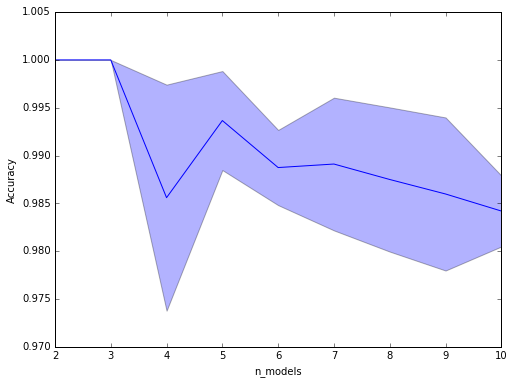

In [7]:
models = ["honda_civic", "hyundai_accent", "hyundai_solaris", "kia_ceed",
          "kia_rio", "lada_kalina", "mazda_3", "nissan_qashqai",
          "opel_astra", "toyota_camry"]

X, y = [], []
grid_scores = []

for i, model in enumerate(models):
    for img_name in glob.iglob("dataset/cropped/{}/*".format(model)):
        img = io.imread(fname=img_name, as_grey=True)
        img = transform.resize(image=img, output_shape=(192, 240))

        fd = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2))

        X.append(fd)
        y.append(i)

    if i > 0:
        clf = RandomForestClassifier(n_estimators=300, random_state=42)
        cv = KFold(len(X), n_folds=5, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X, y, scoring="accuracy", cv=cv)
        grid_scores.append(scores)

plot_quality(grid_scores, range(2, 11), "n_models")

### Подбор параметров гистограммы градиентов

In [7]:
from sklearn.grid_search import GridSearchCV

# TODO

## Вторая модель - Convolutional Neural Network

Начнем с простой архитектуры - сеть с двумя сверточными слоями.

In [8]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import rectify, softmax
from nolearn.lasagne import NeuralNet

models = ["honda_civic", "hyundai_accent", "hyundai_solaris", "kia_ceed",
          "kia_rio", "lada_kalina", "mazda_3", "nissan_qashqai",
          "opel_astra", "toyota_camry"]

X, y = [], []

for i, model in enumerate(models):
    for img_name in glob.iglob("dataset/cropped/{}/*".format(model)):
        img = io.imread(fname=img_name, as_grey=True)
        img = transform.resize(image=img, output_shape=(192, 240))

        X.append(img)
        y.append(i)
        
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int32)
X = X.reshape((-1, 1, 192, 240))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

net = NeuralNet(
    layers=[
            ('input', layers.InputLayer),
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('dense', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('output', layers.DenseLayer),
            ],

    # input layer
    input_shape=(None, 1, 192, 240),

    # layer conv2d1
    conv2d1_num_filters=16,
    conv2d1_filter_size=(3, 3),
    conv2d1_nonlinearity=rectify,

    # layer maxpool1
    maxpool1_pool_size=(2, 2),

    # layer conv2d2
    conv2d2_num_filters=32,
    conv2d2_filter_size=(2, 2),
    conv2d2_nonlinearity=rectify,

    # layer maxpool2
    maxpool2_pool_size=(2, 2),

    # dropout1
    dropout1_p=0.5,

    # dense
    dense_num_units=256,
    dense_nonlinearity=rectify,

    # dropout2
    dropout2_p=0.5,

    # output
    output_nonlinearity=softmax,
    output_num_units=10,

    # optimization method params
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,
    max_epochs=16,
    verbose=1,
)

net.fit(X_train, y_train)

y_pred = net.predict(X_test)
print((y_pred == y_test).mean())

/home/misha/Lasagne/lasagne/layers/conv.py:499: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)
/home/misha/Lasagne/lasagne/layers/conv.py:499: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 22721482 learnable parameters

## Layer information

  #  name      size
---  --------  ----------
  0  input     1x192x240
  1  conv2d1   16x190x238
  2  maxpool1  16x95x119
  3  conv2d2   32x94x118
  4  maxpool2  32x47x59
  5  dropout1  32x47x59
  6  dense     256
  7  dropout2  256
  8  output    10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  --------
      1       2.28214       2.27376      1.00368      0.10126  1268.92s
      2       2.22911       2.20851      1.00933      0.12079  605.49s
      3       2.14480       2.08401      1.02917      0.20252  490.29s
      4       1.97162       1.78779      1.10283      0.38822  735.45s
      5       1.71051       1.46841      1.16488      0.48077  764.68s
      6       1.37254       1.04596      1.31224      0.70162  467.82s
      7       1.04859       0.80843      1.29708      0.75541  719.38s
      8       0.78671       0.62943 

In [9]:
from sklearn.externals import joblib

joblib.dump(net, "simple_cnn.pkl", compress=3)

['simple_cnn.pkl', 'simple_cnn.pkl_01.npy.z']

### Визуализация результатов

Вспомогательная функция, для визуализации матрицы ошибок

In [ ]:
from sklearn.metrics import confusion_matrix

def visualize_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm)
    plt.title("Confusion matrix")
    plt.colorbar()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Отобразим матрицу ошибок

/home/misha/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


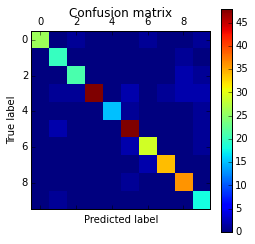

In [ ]:
visualize_confusion_matrix(y_test, y_pred)